In [2]:
import sys
import geopandas
from pathlib import Path
import os
import folium
import pandas as pd

/tmp/ipykernel_26491/2621014091.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [3]:
# se ajusta la memoria máxima a utilizar
# (por defecto usa el 80% de la memoria disponible)
sys.argv.append(["--max-memory", "2G"])

In [4]:
combined_route = "../web-scrapper/portalinmobiliario.com/data/santiago_total/combined.csv" # reemplazar por el archivo definitivo
combined_df = pd.read_csv(combined_route)
combined_df.head()

direccion   precio   
0  Lira 245, Santa Isabel, Santiago, RM (Metropol...  580.000  \
1  Chiloé 1951, Franklin - Biobío, Santiago, RM (...  450.000   
2  Matucana 1161, Parque Los Reyes, Santiago, RM ...  522.000   
3  Santa Elena 2100 - 2400, San Joaquín, Chile, S...  548.000   
4  Santa Isabel, Santa Isabel, Santiago, RM (Metr...  450.000   

                        gastos_comunes   
0  Gastos comunes aproximados $ 85.000  \
1  Gastos comunes aproximados $ 80.000   
2  Gastos comunes aproximados $ 95.000   
3  Gastos comunes aproximados $ 93.000   
4  Gastos comunes aproximados $ 75.000   

                              caracteristicas  num_caracteristicas   
0     58 m² totales / 2 dormitorios / 2 baños                    3  \
1  48.98 m² totales / 2 dormitorios / 2 baños                    3   
2     58 m² totales / 3 dormitorios / 2 baños                    3   
3      68 m² totales / 2 dormitorios / 1 baño                    3   
4     47 m² totales / 2 dormitorios / 2 baños                    3   

  fecha_descarga                          fecha_publicacion   
0     2023-05-19  Publicado hace 7 días por Assetplan Chile  \
1     2023-05-19  Publicado hace 8 días por Assetplan Chile   
2     2023-05-19  Publicado hace 8 días por Assetplan Chile   
3     2023-05-19       Publicado hace 59 días por Blue Home   
4     2023-05-19             Publicado hace 6 días por Houm   

                                              titulo   
0     Edificio Lira (1 Est. 1 Bod.) Vista Sur Piso 1  \
1   Edificio Chiloé (1 Est. 1 Bod.) Vista Sur Piso 5   
2  Edificio Matucana (1 Est. 1 Bod.) Vista Norte ...   
3  Santa Elena 2120 -  Departamento 2d2b(4c), San...   
4                Departamento Santa Isabel Id: 76181   

                                                 url    latitud   longitud   
0  https://www.portalinmobiliario.com/MLC-1383404... -33.446453 -70.640080  \
1  https://www.portalinmobiliario.com/MLC-1649868... -33.471713 -70.645341   
2  https://www.portalinmobiliario.com/MLC-1649835... -33.446337 -70.679316   
3  https://www.portalinmobiliario.com/MLC-1424598... -33.205869 -70.728268   
4  https://www.portalinmobiliario.com/MLC-1658084... -33.447116 -70.630407   

     ciudad  
0  Santiago  
1  Santiago  
2  Santiago  
3  Santiago  
4  Santiago

In [5]:
# antes de pasar a int, se tiene que quitar el .
def replace_dot(value):
    value = value.replace('.', '')
    value = int(value)
    if value < 100:
        value = int(value * 36071.45)
    return value

In [6]:
replace_dot("450.000")

450000

In [7]:
# vamos a pasar los precios a int
combined_df["precio"] = combined_df["precio"].replace(combined_df["precio"].values, list(map(replace_dot, combined_df["precio"].values)))

# y agregamos la columna id que será necesaria más tarde
combined_df["id"] = combined_df.index

In [10]:
from aves.features.geo import to_point_geodataframe

<Axes: >

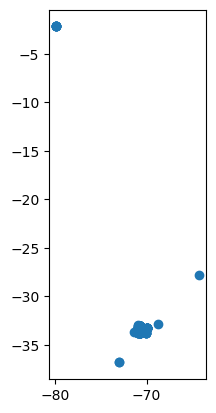

In [11]:
deptos = to_point_geodataframe(combined_df, 'longitud', 'latitud', crs='epsg:20040')
deptos.plot()

In [12]:
# se hace un mapa para pasarlo como parámetro en la siguente celda
# esto para tener un punto específico de Santiago como centro y un nivel de zoom personalizados
mapa_stgo = folium.Map(location=(-33.45, -70.65), zoom_start=16)
mapa_stgo

In [13]:
deptos.explore("precio", 
               m=mapa_stgo, 
               cmap="Reds", 
               marker_kwds={"radius": 12}, 
               tooltip=["direccion","precio","gastos_comunes","caracteristicas","num_caracteristicas"],
               legend_kwds={"scale": False})

In [29]:
# elegir un punto de origen, que va a ser el edificio que se va a estar revisando
origin = deptos.loc[deptos.index == 80].copy()
origin = origin[["direccion", "latitud", "longitud", "id", "geometry"]]
origin

direccion    latitud   longitud   
80  Monjitas 744, Santiago, Chile, Centro Históric... -33.437081 -70.647782  \

    id                     geometry  
80  80  POINT (-70.64778 -33.43708)

In [15]:
origin.explore(color="blue", max_zoom=18, marker_kwds={"radius": 12})

In [16]:
# se toma un punto de destino: el del viaje más frecuente
direccion_destino = "Beauchef 851, Santiago, RM (Metropolitana)"

In [17]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_app3", timeout=5)
from time import sleep

In [18]:
# para sacar las coordenadas de la dirección de destino

max_tries = 10
retry_timeout = 5  # Timeout in seconds

location = None # Se inicializa la ubicacion
latitude = 0
longitude = 0

for try_count in range(1, max_tries + 1):
    try:
        location = geolocator.geocode(direccion_destino)
        break  # Break out of the loop if geocoding is successful
    except Exception as e:
        print("An error occurred:", e)
        print("error number: "+ str(try_count))
        pass

    if try_count < max_tries:
        sleep(retry_timeout)  # Wait for the specified timeout before retrying

if location == None:
    #invalid_targets.append(target)
    latitude = None
    longitude = None
else:
    latitude = location.latitude
    longitude = location.longitude

print(latitude)
print(longitude)

-33.458387
-70.6648089


In [22]:
destino_df = pd.DataFrame(
    {"direccion": direccion_destino,
     "latitud": latitude,
     "longitud": longitude},
     index=[combined_df.shape[0]]
)
destino_df["id"] = destino_df.index
destino = to_point_geodataframe(destino_df, "longitud", "latitud", crs='epsg:20040')
destino

direccion    latitud   longitud    id   
5370  Beauchef 851, Santiago, RM (Metropolitana) -33.458387 -70.664809  5370  \

                         geometry  
5370  POINT (-70.66481 -33.45839)

In [23]:
destino.explore(color="blue", max_zoom=18, marker_kwds={"radius": 12})

In [25]:
from r5py import TransportNetwork

In [26]:
transport_network = TransportNetwork(
    "clipped-scl-osm.pbf", ["santiago_dptm_gtfs.zip"]
)

Running in non-interactive shell, SIGINT handler is replaced by shell
Signal Handlers:
SIGSEGV: [libjvm.so+0xbe53b0], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGBUS: [libjvm.so+0xbe53b0], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGFPE: [libjvm.so+0xbe53b0], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGPIPE: [libjvm.so+0xbe53b0], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGXFSZ: [libjvm.so+0xbe53b0], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGILL: [libjvm.so+0xbe53b0], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGUSR2: [libjvm.so+0xbe5250], sa_mask[0]=00000000000000000000000000000000, sa_flags=SA_RESTART|SA_SIGINFO
SIGHUP: [libjvm.so+0xbe5900], sa_mask[0]=11111111011111111101111111111110, sa_flags=SA_RESTART|SA_SIGINFO
SIGINT: SIG_IGN, sa_mask[0]=00000000000000000000000000000000,

In [27]:
from r5py import TravelTimeMatrixComputer, TransitMode, LegMode
import datetime

In [30]:
travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins=origin,
    destinations=destino,
    departure=datetime.datetime(2023, 7, 3, 7, 0), # esta hora también la debería ingresar el usuario
    transport_modes=[TransitMode.TRANSIT, LegMode.WALK],
    breakdown=True
)

travel_time_matrix_detailed = travel_time_matrix_computer.compute_travel_times()
travel_time_matrix_detailed

/home/mprado/miniconda3/envs/aves/lib/python3.9/site-packages/r5py/r5/regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
/home/mprado/miniconda3/envs/aves/lib/python3.9/site-packages/r5py/r5/regional_task.py:395: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLon = origin.x


from_id  to_id  travel_time           routes     board_stops   
0       80   5370           25  [L5V, L2R, 507]  [75, 4, PA450]  \

     alight_stops       ride_times  access_time  egress_time  transfer_time   
0  [4, 70, PA322]  [1.3, 4.4, 3.6]          4.6          3.3            1.3  \

        wait_times  total_time  n_iterations  
0  [1.1, 3.7, 1.2]        24.4             8